=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===

1 seizure / week (baseline seizure prob = 0.1331)
-------------------------------------------------------
AUC = 0.60: Cannot reach legal-limit safety threshold

AUC = 0.80: FPR = 1.000, Sensitivity = 1.000
   Days in warning per year: 365.0
   Days allowed to drive per year: 0.0
   Average interval between driving days: 59333.2 days

AUC = 0.90: FPR = 0.979, Sensitivity = 1.000
   Days in warning per year: 358.3
   Days allowed to drive per year: 6.7
   Average interval between driving days: 54.7 days


1 seizure / month (baseline seizure prob = 0.0328)
-------------------------------------------------------
AUC = 0.60: Cannot reach legal-limit safety threshold

AUC = 0.80: FPR = 0.997, Sensitivity = 1.000
   Days in warning per year: 364.1
   Days allowed to drive per year: 0.9
   Average interval between driving days: 395.5 days

AUC = 0.90: FPR = 0.867, Sensitivity = 0.998
   Days in warning per year: 317.9
   Day

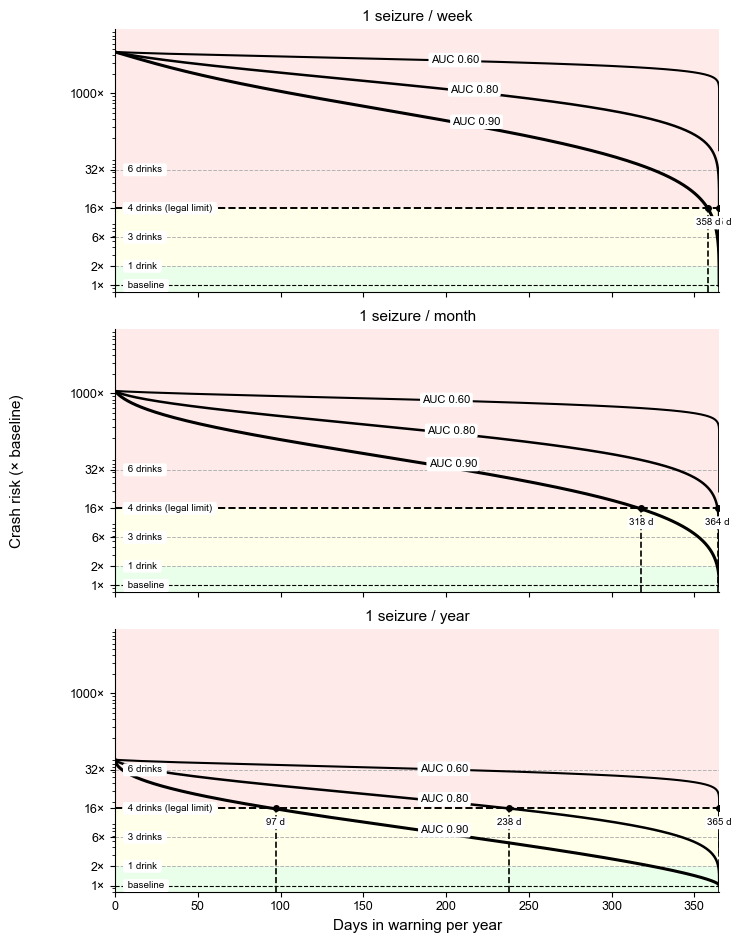

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -------------------------------------------------
# Global style (good for journals like JAMA Neurol)
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
})

# -------------------------
# Configuration
# -------------------------
R = [1/7, 1/30, 1/365]
R_labels = ['1 seizure / week', '1 seizure / month', '1 seizure / year']

# Updated AUC values
auc_values = [0.60, 0.80, 0.90]
auc_linewidth = {0.60: 1.5, 0.80: 1.8, 0.90: 2.2}

# Reference crash risks (baseline sober risk p0)
p0 = 1.5e-5
p1 = p0 * 2**(0.02/0.02)   # 1 drink
p3 = p0 * 2**(0.05/0.02)   # 3 drinks
p4 = p0 * 2**(0.08/0.02)   # 4 drinks (legal limit)
p6 = p0 * 2**(0.12/0.02)   # 6 drinks

y_limits = [0.8, 1e4]
p_crash_seizure = 0.5  # P(crash | seizure while driving)

# -------------------------
# Helper
# -------------------------
def compute_curve_for_auc(auc, p_seizure):
    """Return days_warning, pc_relative, sensitivity, FPR for given AUC and daily seizure prob."""
    m = np.sqrt(2) * norm.ppf(auc)
    th = np.linspace(-10, 10, 1000)

    s_ana = norm.cdf(m - th)      # sensitivity
    f_ana = 1 - norm.cdf(th)      # FPR

    num = norm.cdf(th - m) * p_seizure
    den = num + norm.cdf(th) * (1 - p_seizure)
    pn_ana = num / den            # P(seizure | "safe" day)

    p_warning = s_ana * p_seizure + f_ana * (1 - p_seizure)
    days_warning = p_warning * 365

    pc_ana = pn_ana * p_crash_seizure + (1 - pn_ana) * p0
    pc_relative = pc_ana / p0

    return days_warning, pc_relative, s_ana, f_ana

# -------------------------
# Figure 1: crash risk vs warning days
# -------------------------
fig, axes = plt.subplots(3, 1, figsize=(7.5, 9.5), sharex=True)

print('=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===\n')

for j, (r, ax) in enumerate(zip(R, axes)):
    # Baseline daily seizure probability (Poisson process)
    p = 1 - np.exp(-r)
    print(f'{R_labels[j]} (baseline seizure prob = {p:.4f})')
    print('-' * 55)

    # Light-pink shaded "unsafe" region above legal limit (4 drinks)
    ax.axhspan(p4/p0, y_limits[1],
               facecolor='#ffcccc', alpha=0.4, zorder=0)
    
    # Light-yellow shaded region between 1 drink and 4 drinks (legal limit)
    ax.axhspan(p1/p0, p4/p0,
               facecolor='#ffffcc', alpha=0.4, zorder=0)
    
    # Light-green shaded "safe" region below 1 drink
    ax.axhspan(y_limits[0], p1/p0,
               facecolor='#ccffcc', alpha=0.4, zorder=0)

    # Horizontal reference lines
    ax.axhline(y=1,       color='k',        linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(y=p1/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p3/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p4/p0,   color='black',    linestyle='--', linewidth=1.4, zorder=2)
    ax.axhline(y=p6/p0,   color='0.7',      linestyle='--', linewidth=0.7, zorder=1)

    # Store crossing info for later labeling (to ensure labels are on top)
    crossing_info = []

    # Curves for each AUC
    for auc in auc_values:
        days_warning, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)

        ax.plot(days_warning, pc_rel,
                color='k', linewidth=auc_linewidth[auc], zorder=3)

        # Sort for cross detection
        idx_sort = np.argsort(days_warning)
        dw_sorted = days_warning[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]

        # First point where crash risk drops below legal-limit threshold
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            dw_cross = dw_sorted[idx_cross]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]

            # Store for later plotting on top
            crossing_info.append((dw_cross, auc, s_cross, f_cross, p))

            # Text output for table / checking
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
            avg_interval = 1 / p_safe

            print(f'AUC = {auc:.2f}: FPR = {f_cross:.3f}, Sensitivity = {s_cross:.3f}')
            print(f'   Days in warning per year: {dw_cross:.1f}')
            print(f'   Days allowed to drive per year: {days_driving:.1f}')
            print(f'   Average interval between driving days: {avg_interval:.1f} days\n')
        else:
            print(f'AUC = {auc:.2f}: Cannot reach legal-limit safety threshold\n')

        # Label the curve around its median x
        mid_idx = np.argmin(np.abs(days_warning - np.median(days_warning)))
        ax.text(days_warning[mid_idx], pc_rel[mid_idx],
                f'AUC {auc:.2f}',
                fontsize=8, ha='left', va='center',
                bbox=dict(boxstyle='round,pad=0.2',
                          facecolor='white', edgecolor='none'),
                zorder=5)

    # Now plot crossing markers and labels ON TOP (highest z-order)
    for dw_cross, auc, s_cross, f_cross, p in crossing_info:
        # Vertical black dashed line
        ax.plot([dw_cross, dw_cross],
                [y_limits[0], p4/p0],
                'k--', linewidth=1.2, zorder=6)
        # Black marker at crossing point (smaller)
        ax.plot(dw_cross, p4/p0,
                'o', color='black', markersize=4, zorder=7)

        # Label with number of warning days - ON TOP with opaque box
        ax.text(dw_cross, p4/p0*0.7,
                f'{dw_cross:.0f} d',
                fontsize=7, ha='center', va='top',
                bbox=dict(boxstyle='round,pad=0.2',
                          facecolor='white', edgecolor='none', alpha=1.0),
                zorder=8)

    # Panel formatting
    ax.set_ylim(y_limits)
    ax.set_xlim([0, 365])
    ax.set_yscale('log')
    ax.set_title(R_labels[j], fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Drink labels
    ax.text(6, 1,        ' baseline ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
            zorder=5)
    ax.text(6, p1/p0,    ' 1 drink ',                fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
            zorder=5)
    ax.text(6, p3/p0,    ' 3 drinks ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
            zorder=5)
    ax.text(6, p4/p0,    ' 4 drinks (legal limit) ', fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
            zorder=5)
    ax.text(6, p6/p0,    ' 6 drinks ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'),
            zorder=5)

    # Intuitive y-ticks
    ax.set_yticks([1, p1/p0, p3/p0, p4/p0, p6/p0, 1e3])
    ax.set_yticklabels(['1×', '2×', '6×', '16×', '32×', '1000×'])

    print()

# Shared labels
fig.text(0.02, 0.5, 'Crash risk (× baseline)', va='center',
         rotation='vertical', fontsize=11)
axes[-1].set_xlabel('Days in warning per year', fontsize=11)

plt.tight_layout()
plt.subplots_adjust(left=0.16)

fig.savefig('Figure_S3.pdf',
            facecolor='white', bbox_inches='tight')

plt.show()


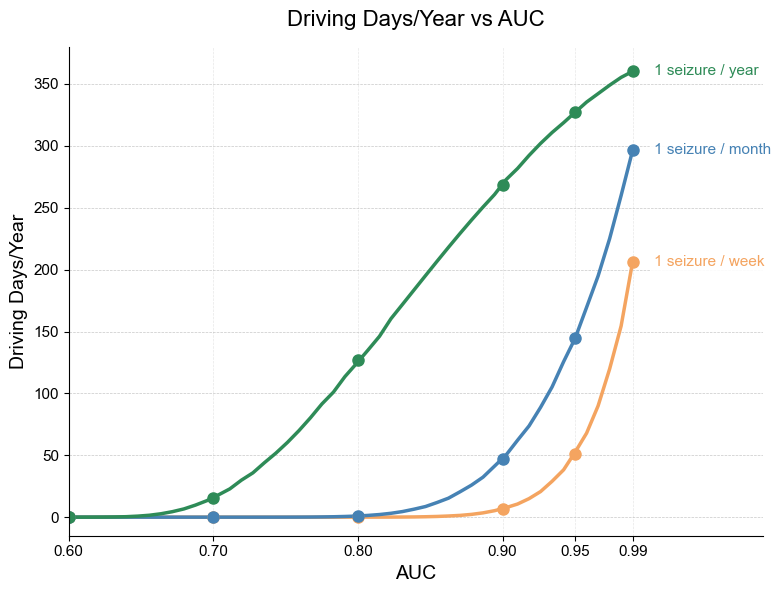


Figure saved as Figure_1_Main.pdf

FIGURE LEGEND:

Figure 1. Annual driving days permitted under forecasting-based driving policy
to maintain crash risk below legal intoxication threshold (16× baseline).

Curves show the relationship between forecasting algorithm performance (AUC)
and the number of days per year a patient can safely drive for three seizure
frequencies. Filled circles mark key AUC values (0.60, 0.70, 0.80, 0.90, 0.95,
0.99). Curves are calculated analytically using the equal-variance binormal ROC
model with Bayes' theorem. Even high-performance algorithms (AUC = 0.90) require
substantial driving restrictions for patients with frequent seizures.



Driving Days Data (at marker points):
------------------------------------------------------------
1 seizure / week:
  AUC 0.60:    0.0 days/year
  AUC 0.70:    0.0 days/year
  AUC 0.80:    0.0 days/year
  AUC 0.90:    6.7 days/year
  AUC 0.95:   50.9 days/year
  AUC 0.99:  206.4 days/year

1 seizure / month:
  AUC 0.60:    0

In [6]:
# -------------------------------------------------
# Figure: Driving Days/Year vs AUC (Main Text Figure)
# -------------------------------------------------

# AUC values for smooth curves (many intermediate points)
auc_grid_smooth = np.linspace(0.60, 0.99, 50)

# AUC values to show with markers
auc_grid_markers = np.array([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])

# Colors for each seizure frequency
colors = {
    '1 seizure / week': '#F4A460',    # Sandy brown / orange
    '1 seizure / month': '#4682B4',   # Steel blue
    '1 seizure / year': '#2E8B57',    # Sea green
}

# Compute driving days for smooth curves
driving_days_smooth = {label: [] for label in R_labels}
driving_days_markers = {label: [] for label in R_labels}

for r, label in zip(R, R_labels):
    p = 1 - np.exp(-r)
    
    # Compute for smooth curve
    for auc in auc_grid_smooth:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)
        
        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]
        
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]
            
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
        else:
            days_driving = 0
        
        driving_days_smooth[label].append(days_driving)
    
    # Compute for marker points
    for auc in auc_grid_markers:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)
        
        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]
        
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]
            
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
        else:
            days_driving = 0
        
        driving_days_markers[label].append(days_driving)

# Create figure with Arial font
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
})

fig_main, ax_main = plt.subplots(figsize=(8, 6))

# Plot smooth curves (no markers)
for label in R_labels:
    ax_main.plot(auc_grid_smooth, driving_days_smooth[label],
                 linewidth=2.5, color=colors[label])

# Plot markers only at key AUC values
for label in R_labels:
    ax_main.plot(auc_grid_markers, driving_days_markers[label],
                 marker='o', markersize=8, linewidth=0,
                 color=colors[label])

# Add inline labels directly on curves (Tufte style)
# Position labels at the end
label_positions = {
    '1 seizure / year': (0.99, driving_days_markers['1 seizure / year'][-1]),
    '1 seizure / month': (0.99, driving_days_markers['1 seizure / month'][-1]),
    '1 seizure / week': (0.99, driving_days_markers['1 seizure / week'][-1]),
}

for label in R_labels:
    x, y = label_positions[label]
    ax_main.text(x + 0.015, y, label,
                fontsize=11, ha='left', va='center',
                color=colors[label],
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor='white', 
                         edgecolor='none',
                         alpha=0.9))

# Formatting
ax_main.set_xlim(0.60, 1.08)
ax_main.set_ylim(-15, 380)
ax_main.set_xlabel('AUC', fontsize=14)
ax_main.set_ylabel('Driving Days/Year', fontsize=14)
ax_main.set_title('Driving Days/Year vs AUC', fontsize=16, pad=15)

# Grid
ax_main.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
ax_main.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.3)

# Clean spines
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)

# Tick formatting - max shown is 0.99
ax_main.tick_params(axis='both', labelsize=11)
ax_main.set_xticks([0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
ax_main.set_xticklabels(['0.60', '0.70', '0.80', '0.90', '0.95', '0.99'])

# Y-axis starts at 0
ax_main.set_yticks([0, 50, 100, 150, 200, 250, 300, 350])

plt.tight_layout()

fig_main.savefig('Figure_S3.pdf', facecolor='white', bbox_inches='tight')
plt.show()

# Print figure legend
print('\nFigure saved as Figure_S3.pdf')
print('\n' + '='*80)
print('FIGURE LEGEND:')
print('='*80)
print()
print('Figure 1. Annual driving days permitted under forecasting-based driving policy')
print('to maintain crash risk below legal intoxication threshold (16× baseline).')
print()
print('Curves show the relationship between forecasting algorithm performance (AUC)')
print('and the number of days per year a patient can safely drive for three seizure')
print('frequencies. Filled circles mark key AUC values (0.60, 0.70, 0.80, 0.90, 0.95,')
print('0.99). Curves are calculated analytically using the equal-variance binormal ROC')
print('model with Bayes\' theorem. Even high-performance algorithms (AUC = 0.90) require')
print('substantial driving restrictions for patients with frequent seizures.')
print()
print('='*80)
print()
print('\nDriving Days Data (at marker points):')
print('-' * 60)
for label in R_labels:
    print(f'{label}:')
    for auc, days in zip(auc_grid_markers, driving_days_markers[label]):
        print(f'  AUC {auc:.2f}: {days:6.1f} days/year')
    print()


In [ ]:
# -------------------------------------------------
# Figure 2: minimum warning days vs AUC (inline labels on curves)
# -------------------------------------------------

auc_grid = np.linspace(0.60, 0.99, 80)

min_warning_days = {label: [] for label in R_labels}

for r, label in zip(R, R_labels):
    p = 1 - np.exp(-r)
    for auc in auc_grid:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)

        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]

        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            min_dw = dw_sorted[idx_cross[0]]
        else:
            min_dw = np.nan
        min_warning_days[label].append(min_dw)

# Convert to arrays
for k in min_warning_days:
    min_warning_days[k] = np.array(min_warning_days[k])

fig2, ax2 = plt.subplots(figsize=(7, 4.5))

styles = {
    '1 seizure / week':  ('-',  2.0),
    '1 seizure / month': ('--', 2.0),
    '1 seizure / year':  (':',  2.2),
}

# Plot the three curves
for label in R_labels:
    ls, lw = styles[label]
    ax2.plot(auc_grid, min_warning_days[label],
             linestyle=ls, linewidth=lw, color='k')

ax2.set_xlim(0.60, 0.99)
ax2.set_ylim(0, 365)
ax2.set_xlabel('AUC of seizure forecasting algorithm', fontsize=11)
ax2.set_ylabel('Minimum days in warning per year\n(to reach legal-limit crash risk)', fontsize=10)

# Shared tick locations for both y-axes
ticks = np.arange(0, 401, 50)
ax2.set_yticks(ticks)
ax2.set_ylim(0, 365)

ax2b = ax2.twinx()
ax2b.set_ylim(0, 365)
ax2b.set_yticks(ticks)
ax2b.set_yticklabels([f'{int(365 - v)}' for v in ticks])
ax2b.set_ylabel('Maximum days allowed to drive per year', fontsize=10)

ax2.grid(axis='y', linestyle=':', linewidth=0.5)

# -------- inline labels ON the curves, inside the plot --------
# choose positions ~50–70% along the reachable AUC range, so they sit nicely inside
label_frac = {
    '1 seizure / week': 0.85,
    '1 seizure / month': 0.65,
    '1 seizure / year': 0.55,
}

for label in R_labels:
    y_vals = min_warning_days[label]
    valid_idx = np.where(~np.isnan(y_vals))[0]
    if len(valid_idx) == 0:
        continue

    frac = label_frac[label]
    i = valid_idx[int(frac * len(valid_idx))]
    x = auc_grid[i]-.035
    y = y_vals[i]

    ax2.text(
        x, y,
        label,
        fontsize=9,
        va='center',
        ha='left',
        bbox=dict(
            boxstyle='round,pad=0.2',
            facecolor='white',
            edgecolor='none',
            alpha=0.9
        )
    )

fig2.tight_layout()
fig2.savefig('Figure_S3.pdf',
             facecolor='white', bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for schematic
m = 2.0        # example separation (AUC ≈ 0.92)
t = 0.75       # threshold for illustration
x = np.linspace(-4, 6, 500)

# Distributions
y_non = norm.pdf(x, 0, 1)
y_seiz = norm.pdf(x, m, 1)

fig, ax = plt.subplots(figsize=(7, 4))

# Plot the two Gaussians
ax.plot(x, y_non, color='black', linewidth=2, label='Non-seizure (N(0,1))')
ax.plot(x, y_seiz, color='black', linestyle='--', linewidth=2, label='Seizure (N(m,1))')

# Threshold line
ax.axvline(t, color='black', linestyle=':', linewidth=2)
ax.text(t, max(y_seiz)*1.05, 'Threshold t', ha='center', va='bottom', fontsize=10)

# Sensitivity arrow
ax.annotate(
    '', xy=(t, 0.35), xytext=(m, 0.35),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+m)/2, 0.38, r"Sensitivity $=1-\Phi(t-m)$", ha='center', va='bottom', fontsize=9)

# FPR arrow
ax.annotate(
    '', xy=(t, 0.25), xytext=(0, 0.25),
    arrowprops=dict(arrowstyle='<->', linewidth=1.5)
)
ax.text((t+0)/2, 0.28, r"FPR $=1-\Phi(t)$", ha='center', va='bottom', fontsize=9)

# Bayes box under curves
bayes_text = (
    r"$P(\text{seizure} \mid \text{safe}) = "
    r"\frac{\Phi(t-m)\, p}{\Phi(t-m)\, p + \Phi(t)(1-p)}$"
)

ax.text(
    1.0, -0.10, bayes_text,
    ha='center', va='top', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
    transform=ax.transData
)

# Clean formatting
ax.set_ylim(-0.15, max(y_seiz)*1.3)
ax.set_xlim(-3, 5)
ax.set_yticks([])
ax.set_xlabel("Forecast score S")
ax.set_title("Schematic of Symmetric Binormal Forecast Model (Figure S0)")

plt.tight_layout()

# Save all formats
fig.savefig("Figure_S2.pdf", bbox_inches='tight')

plt.show()


In [ ]:
# %% [markdown]
# # ROC Shape Sensitivity Analysis: Drink-Equivalent Crash Risk
# 
# Compares different ROC curve shapes (all with AUROC ≈ 0.8) using the same
# visualization as Figure 1, with crash risk expressed as drink equivalents.

# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

# Journal-friendly style
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 9,
})

# %%
# -------------------------
# Configuration
# -------------------------
RNG_SEED = 12345
rng = np.random.default_rng(RNG_SEED)

# Seizure frequencies
R = [1/7, 1/30, 1/365]
R_labels = ['1 seizure / week', '1 seizure / month', '1 seizure / year']

# Reference crash risks (baseline sober risk p0)
p0 = 1.5e-5
p1 = p0 * 2**(0.02/0.02)   # 1 drink
p3 = p0 * 2**(0.05/0.02)   # 3 drinks
p4 = p0 * 2**(0.08/0.02)   # 4 drinks (legal limit)
p6 = p0 * 2**(0.12/0.02)   # 6 drinks

y_limits = [0.8, 1e4]
p_crash_seizure = 0.5  # P(crash | seizure while driving)

# Target AUC for all models
TARGET_AUC = 0.90

# %%
# -------------------------
# ROC curve computation for different shapes
# -------------------------

def compute_curve_binormal_equal_var(auc, p_seizure, n_points=1000):
    """
    Equal-variance binormal model (standard symmetric ROC).
    This is the same as the original code.
    """
    m = np.sqrt(2) * norm.ppf(auc)
    th = np.linspace(-10, 10, n_points)
    
    sensitivity = norm.cdf(m - th)
    fpr = 1 - norm.cdf(th)
    
    # P(seizure | "safe" day) via Bayes
    num = norm.cdf(th - m) * p_seizure
    den = num + norm.cdf(th) * (1 - p_seizure)
    p_seiz_given_safe = num / den
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    pc = p_seiz_given_safe * p_crash_seizure + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    return days_warning, pc_relative, sensitivity, fpr


def compute_curve_binormal_unequal_var(p_seizure, n_points=1000):
    """
    Unequal-variance binormal model (S-shaped ROC).
    
    Negatives ~ N(0, 1), Positives ~ N(mu, sigma) with sigma > 1.
    Parameters tuned to give AUC ≈ 0.90.
    """
    # Parameters tuned for AUC ~ 0.90
    mu_pos = 2.4
    sigma_pos = 1.4
    
    th = np.linspace(-8, 12, n_points)
    
    # Sensitivity = P(score > th | positive) = 1 - Phi((th - mu_pos)/sigma_pos)
    sensitivity = 1 - norm.cdf((th - mu_pos) / sigma_pos)
    # FPR = P(score > th | negative) = 1 - Phi(th)
    fpr = 1 - norm.cdf(th)
    
    # P(negative | score < th) for each class
    # P(score < th | positive) = Phi((th - mu_pos)/sigma_pos)
    # P(score < th | negative) = Phi(th)
    p_below_th_pos = norm.cdf((th - mu_pos) / sigma_pos)
    p_below_th_neg = norm.cdf(th)
    
    # P(seizure | safe day) = P(seizure | score < th)
    num = p_below_th_pos * p_seizure
    den = num + p_below_th_neg * (1 - p_seizure)
    p_seiz_given_safe = num / den
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    pc = p_seiz_given_safe * p_crash_seizure + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    return days_warning, pc_relative, sensitivity, fpr


def compute_curve_mixture_positive(p_seizure, n_sim=500_000):
    """
    Mixture model in positive class (hooked ROC).
    
    Negatives ~ N(0, 1)
    Positives ~ mixture: 70% N(mu_easy, 1) + 30% N(mu_hard, 1)
    
    This creates a "hooked" ROC that rises quickly then flattens.
    Parameters tuned for AUC ~ 0.90.
    """
    # Parameters tuned for AUC ~ 0.90
    mu_easy = 2.5
    mu_hard = 0.8
    w_easy = 0.7
    
    # Simulate to get empirical ROC
    neg = rng.normal(0, 1, n_sim)
    pos = np.where(
        rng.random(n_sim) < w_easy,
        rng.normal(mu_easy, 1, n_sim),
        rng.normal(mu_hard, 1, n_sim)
    )
    
    # Compute ROC by sweeping thresholds
    all_scores = np.concatenate([neg, pos])
    thresholds = np.percentile(all_scores, np.linspace(100, 0, 500))
    
    sensitivity = np.array([np.mean(pos > th) for th in thresholds])
    fpr = np.array([np.mean(neg > th) for th in thresholds])
    
    # For each threshold, compute P(seizure | safe)
    # P(score < th | pos) and P(score < th | neg)
    p_below_pos = np.array([np.mean(pos <= th) for th in thresholds])
    p_below_neg = np.array([np.mean(neg <= th) for th in thresholds])
    
    num = p_below_pos * p_seizure
    den = num + p_below_neg * (1 - p_seizure)
    with np.errstate(divide='ignore', invalid='ignore'):
        p_seiz_given_safe = np.where(den > 0, num / den, 0)
    
    p_warning = sensitivity * p_seizure + fpr * (1 - p_seizure)
    days_warning = p_warning * 365
    
    pc = p_seiz_given_safe * p_crash_seizure + (1 - p_seiz_given_safe) * p0
    pc_relative = pc / p0
    
    # Compute AUC for verification
    order = np.argsort(fpr)
    auc = np.trapz(sensitivity[order], fpr[order])
    
    return days_warning, pc_relative, sensitivity, fpr, auc


# %%
# -------------------------
# Define model configurations
# -------------------------

# Colors and styles for each ROC shape
model_configs = [
    {
        "name": "Equal-variance binormal",
        "compute_func": lambda p: compute_curve_binormal_equal_var(TARGET_AUC, p),
        "color": "black",
        "linewidth": 2.0,
    },
    {
        "name": "Unequal-variance (S-shaped)",
        "compute_func": lambda p: compute_curve_binormal_unequal_var(p),
        "color": "#0066cc",  # blue
        "linewidth": 1.8,
    },
    {
        "name": "Mixture model (hooked)",
        "compute_func": lambda p: compute_curve_mixture_positive(p)[:4],  # exclude AUC return
        "color": "#cc3300",  # red
        "linewidth": 1.8,
    },
]

# %%
# -------------------------
# Verify AUCs
# -------------------------
print("Verifying AUCs for each model shape:\n")

test_p = 0.02  # arbitrary seizure prob for verification
for cfg in model_configs:
    dw, pc, sens, fpr_arr = cfg["compute_func"](test_p)
    order = np.argsort(fpr_arr)
    auc = np.trapz(sens[order], fpr_arr[order])
    print(f"  {cfg['name']}: AUC = {auc:.3f}")

print()

# %%
# -------------------------
# Figure: Crash risk vs warning days (drink equivalents)
# -------------------------

fig, axes = plt.subplots(3, 1, figsize=(7.5, 9.5), sharex=True)

print('=== Driving Statistics at Legal-Limit (4-drink) Safety Threshold ===\n')

for j, (r, ax) in enumerate(zip(R, axes)):
    # Baseline daily seizure probability (Poisson process)
    p_seizure = 1 - np.exp(-r)
    print(f'{R_labels[j]} (baseline seizure prob = {p_seizure:.4f})')
    print('-' * 60)

    # Colored bands
    ax.axhspan(p4/p0, y_limits[1], facecolor='#ffcccc', alpha=0.4, zorder=0)  # unsafe
    ax.axhspan(p1/p0, p4/p0, facecolor='#ffffcc', alpha=0.4, zorder=0)        # caution
    ax.axhspan(y_limits[0], p1/p0, facecolor='#ccffcc', alpha=0.4, zorder=0)  # safe

    # Reference lines
    ax.axhline(y=1,     color='k',     linestyle='--', linewidth=0.8, zorder=1)
    ax.axhline(y=p1/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p3/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)
    ax.axhline(y=p4/p0, color='black', linestyle='--', linewidth=1.4, zorder=2)
    ax.axhline(y=p6/p0, color='0.7',   linestyle='--', linewidth=0.7, zorder=1)

    crossing_info = []

    for cfg in model_configs:
        days_warn, pc_rel, sens, fpr_arr = cfg["compute_func"](p_seizure)
        
        # Sort by days_warning
        order = np.argsort(days_warn)
        days_warn = days_warn[order]
        pc_rel = pc_rel[order]
        sens = sens[order]
        fpr_arr = fpr_arr[order]
        
        # Plot curve
        ax.plot(days_warn, pc_rel,
                color=cfg["color"], linewidth=cfg["linewidth"], zorder=3)

        # Find crossing point at legal limit
        idx_cross = np.where(pc_rel < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            dw_cross = days_warn[idx_cross]
            s_cross = sens[idx_cross]
            f_cross = fpr_arr[idx_cross]
            
            crossing_info.append((dw_cross, cfg["name"], s_cross, f_cross, cfg["color"]))
            
            # Stats
            p_warning_cross = s_cross * p_seizure + f_cross * (1 - p_seizure)
            p_safe_cross = 1 - p_warning_cross
            days_driving = p_safe_cross * 365
            
            print(f'{cfg["name"]}:')
            print(f'   FPR = {f_cross:.3f}, Sensitivity = {s_cross:.3f}')
            print(f'   Days in warning/year: {dw_cross:.1f}')
            print(f'   Days allowed to drive/year: {days_driving:.1f}')
            print()
        else:
            print(f'{cfg["name"]}: Cannot reach legal-limit threshold\n')

        # Label the curve near its median x position
        mid_idx = np.argmin(np.abs(days_warn - np.median(days_warn)))
        # Offset labels vertically to avoid overlap
        label_offset = 1.0
        ax.text(days_warn[mid_idx] + 10, pc_rel[mid_idx] * label_offset,
                cfg["name"].split()[0],  # Short name
                fontsize=7, ha='left', va='center', color=cfg["color"],
                bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                          edgecolor='none', alpha=0.9), zorder=5)

    # Plot crossing markers
    for dw_cross, name, s_cross, f_cross, color in crossing_info:
        ax.plot([dw_cross, dw_cross], [y_limits[0], p4/p0],
                '--', color=color, linewidth=1.0, zorder=4)
        ax.plot(dw_cross, p4/p0, 'o', color=color, markersize=4, zorder=7)
        ax.text(dw_cross, p4/p0 * 0.65, f'{dw_cross:.0f}d',
                fontsize=7, ha='center', va='top', color=color,
                bbox=dict(boxstyle='round,pad=0.15', facecolor='white',
                          edgecolor='none', alpha=0.9), zorder=8)

    # Panel formatting
    ax.set_ylim(y_limits)
    ax.set_xlim([0, 365])
    ax.set_yscale('log')
    ax.set_title(R_labels[j], fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Drink labels
    ax.text(6, 1,      ' baseline ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p1/p0,  ' 1 drink ',               fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p3/p0,  ' 3 drinks ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p4/p0,  ' 4 drinks (legal limit) ',fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)
    ax.text(6, p6/p0,  ' 6 drinks ',              fontsize=7, va='center',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none'), zorder=5)

    # Y-ticks as multiples
    ax.set_yticks([1, p1/p0, p3/p0, p4/p0, p6/p0, 1e3])
    ax.set_yticklabels(['1×', '2×', '6×', '16×', '32×', '1000×'])
    
    # Legend only on first panel
    if j == 0:
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color=cfg["color"], linewidth=cfg["linewidth"], 
                   label=cfg["name"])
            for cfg in model_configs
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=7, framealpha=0.9)

    print()

# Shared labels
fig.text(0.02, 0.5, 'Crash risk (× baseline)', va='center',
         rotation='vertical', fontsize=11)
axes[-1].set_xlabel('Days in warning per year', fontsize=11)

plt.tight_layout()
plt.subplots_adjust(left=0.16)

fig.savefig('Figure_S4.pdf', facecolor='white', bbox_inches='tight')
plt.show()

# %%
# -------------------------
# Companion: Show the actual ROC curves
# -------------------------

fig, ax = plt.subplots(figsize=(5, 5))

# Use a fixed seizure prob just to generate the ROC curves for display
p_test = 0.02

for cfg in model_configs:
    dw, pc, sens, fpr_arr = cfg["compute_func"](p_test)
    order = np.argsort(fpr_arr)
    auc = np.trapz(sens[order], fpr_arr[order])
    
    ax.plot(fpr_arr[order], sens[order],
            color=cfg["color"], linewidth=cfg["linewidth"],
            label=f'{cfg["name"]} (AUC={auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=0.8, label='Chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_title('ROC Curve Shapes (all AUROC ≈ 0.9)')
ax.legend(loc='lower right', fontsize=7)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_aspect('equal')

fig.tight_layout()
fig.savefig('Figure_S5.pdf', facecolor='white', bbox_inches='tight')
plt.show()

# %% [markdown]
# ## Summary
# 
# PDFs saved:
# - `Figure_S4.pdf` - Main figure (drink-equivalent visualization)
# - `Figure_S5.pdf` - ROC curves for reference

# Extended AUC Table for Main Text

This cell calculates the comprehensive table showing driving restrictions for all AUC values: 0.60, 0.70, 0.80, 0.90, 0.95, 0.99.

The table can be copied directly into Microsoft Word.

In [ ]:
# -------------------------
# Extended AUC Table Calculation
# -------------------------

# Extended AUC values for comprehensive table
auc_values_extended = [0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

# Store results for table
results_extended = []

print('=' * 80)
print('EXTENDED AUC ANALYSIS: Driving Restrictions Required for Legal-Limit Safety')
print('=' * 80)
print()

for r, label in zip(R, R_labels):
    p = 1 - np.exp(-r)
    print(f'{label} (daily seizure probability = {p:.4f})')
    print('-' * 80)
    
    for auc in auc_values_extended:
        dw, pc_rel, s_ana, f_ana = compute_curve_for_auc(auc, p)
        
        # Sort for cross detection
        idx_sort = np.argsort(dw)
        dw_sorted = dw[idx_sort]
        pc_sorted = pc_rel[idx_sort]
        s_sorted = s_ana[idx_sort]
        f_sorted = f_ana[idx_sort]
        
        # Find crossing point at legal limit
        idx_cross = np.where(pc_sorted < p4/p0)[0]
        if len(idx_cross) > 0:
            idx_cross = idx_cross[0]
            dw_cross = dw_sorted[idx_cross]
            s_cross = s_sorted[idx_cross]
            f_cross = f_sorted[idx_cross]
            
            p_warning_cross = s_cross * p + f_cross * (1 - p)
            p_safe = 1 - p_warning_cross
            days_driving = p_safe * 365
            avg_interval = 1 / p_safe if p_safe > 0 else np.inf
            
            results_extended.append({
                'freq': label,
                'auc': auc,
                'warning': dw_cross,
                'driving': days_driving,
                'interval': avg_interval
            })
            
            print(f'  AUC = {auc:.2f}:')
            print(f'    Warning days/year: {dw_cross:6.1f}')
            print(f'    Driving days/year: {days_driving:6.1f}')
            print(f'    Avg interval:      {avg_interval:6.1f} days')
        else:
            results_extended.append({
                'freq': label,
                'auc': auc,
                'warning': None,
                'driving': None,
                'interval': None
            })
            print(f'  AUC = {auc:.2f}: Cannot reach legal-limit safety threshold')
        print()
    print()

# -------------------------
# Print formatted table for Word
# -------------------------
print('=' * 80)
print('TABLE FOR MICROSOFT WORD (Tab-delimited)')
print('=' * 80)
print()
print('Copy the table below and paste into Word using "Keep Text Only",')
print('then convert to table via: Table → Convert Text to Table → Tabs')
print()
print('-' * 80)
print('Seizure Frequency\tAUC\tWarning Days/Year\tDriving Days/Year\tAvg Days Between Drives')
print('-' * 80)

for r_label in R_labels:
    freq_results = [r for r in results_extended if r['freq'] == r_label]
    for i, res in enumerate(freq_results):
        if i == 0:
            freq_col = res['freq']
        else:
            freq_col = ''
        
        auc_str = f"{res['auc']:.2f}"
        
        if res['warning'] is None:
            warning_str = '—'
            driving_str = '—'
            interval_str = 'Cannot reach safety threshold'
        else:
            warning_str = f"{res['warning']:.0f}"
            driving_str = f"{res['driving']:.0f}"
            # Format interval nicely
            if res['interval'] > 1e6:
                interval_str = '∞'
            elif res['interval'] > 10000:
                interval_str = f"{res['interval']:,.0f}"
            else:
                interval_str = f"{res['interval']:.1f}"
        
        print(f'{freq_col}\t{auc_str}\t{warning_str}\t{driving_str}\t{interval_str}')

print('-' * 80)
print()
print('Table title suggestion:')
print('  "Driving Restrictions Required to Achieve Legal-Limit Crash Risk')
print('   by Seizure Frequency and Forecasting Performance"')
print()
print('=' * 80)